In [1]:
import os
import wave
import base64
import requests
import json

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns
sns.set()

In [2]:
os.getcwd()

'/usr/src/app/sample'

# 元データの確認

## 音声データ

In [3]:
class Wavedata:
    """
    フィールド変数
    -----------

    self.binary           : bytes         byte列
    self.base64           : str           bytesをbase64形式に変換した文字列 
    self.array           : numpy_1d_data 音声ファイルから得られたの時系列データ shape(n_length,)
    self.fs               : int           音声ファイルから得られた音声のサンプリング周波数
    self.times            : numpy_1d_data 音声ファイルから得られたの時系列データの時間軸 shape(n_length,)
    """
    
    def __init__(self, filepath: str):
        self.read_binary(filepath)
        self.read_wavefile(filepath)
    
    
    def read_binary(self, filepath: str):
        wf = open(filepath, 'rb')  
        self.binary = wf.read()
        self.base64 = base64.b64encode(self.binary).decode("UTF-8")
        wf.close()

    def read_wavefile(self, filepath: str):
        wf = wave.open(filepath, "rb")
        # サンプリングレート
        fs = wf.getframerate()
        # getnframes -> 全サンプル
        # readframes -> 指定した長さのフレーム
        binary = wf.readframes(wf.getnframes())
        # frombuffer > バイナリ表記(ヘッダー情報なしの音声部分)をintに変換
        wavedata = np.frombuffer(binary, dtype="int16")
        wf.close()
        
        self.array  = wavedata
        self.fs     = float(fs)
        self.times  = np.arange(0.0, len(self.array)/self.fs, 1/self.fs)
    
    def plot(self, figsize=(20, 6.)):
        df = pd.DataFrame({
            'times[s]': self.times,
            'signal': self.array
        }).set_index('times[s]')
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        df.plot( ax=ax)
        plt.show()

In [4]:
wavedata = Wavedata('./data/sample.wav')

In [5]:
wavedata.array

array([  12,  -31,  -22, ..., -270, -294, -277], dtype=int16)

In [6]:
wavedata.fs

16000.0

In [7]:
wavedata.times

array([0.0000000e+00, 6.2500000e-05, 1.2500000e-04, ..., 2.0623125e+00,
       2.0623750e+00, 2.0624375e+00])

In [8]:
wavedata.binary[0:50]

b'RIFF\xf4\x01\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\xd0\x01\x01\x00\x0c\x00\xe1\xff\xea\xff'

In [11]:
wavedata.base64[0:50]

'UklGRvQBAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZG'

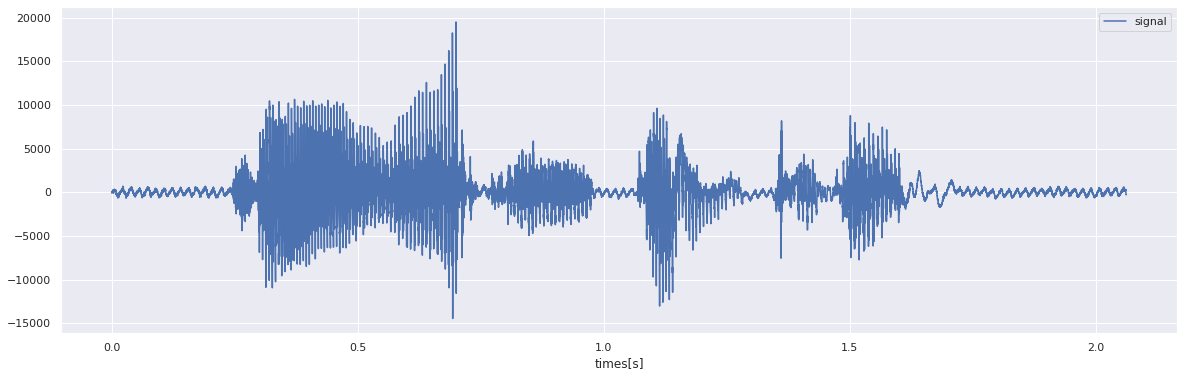

In [12]:
wavedata.plot()

## テキストデータ

In [13]:
f = open('./data/sample.txt')
text = f.read().rstrip()  # ファイル終端まで全て読んだデータを返す
f.close()
text

'きょーわいいてんきだ'

# APIを叩く

In [14]:
# まずは疎通確認
response = requests.get('http://localhost:8000')

In [15]:
# ステータスコード
response.status_code

200

In [16]:
# レスポンス内容
response.json()

{'接続': '確認！'}

In [17]:
# 音素セグメンテーションapiを叩く
headers: dict = {'content-type': 'application/json'}
request_param: dict = {
    'filename': 'sample_01.wav',
    'wavedata': wavedata.base64,
    'textdata': text
}
response = requests.post('http://localhost:8000', headers=headers, json=request_param)

# レスポンスの確認

In [18]:
response

<Response [415]>

In [19]:
response.json()

{'detail': ['ファイル形式が違います']}

In [20]:
import binascii
binascii.hexlify(b'fmt ')

b'666d7420'

In [21]:
binascii.hexlify(b'WAVE')

b'57415645'

In [22]:
binascii.hexlify(b'RIFF')

b'52494646'

In [23]:
binascii.hexlify(b'data')

b'64617461'

In [24]:
'0x52494646' == 'RIFF'

False

In [25]:
b'0x52494646' == 'RIFF'

False